Topic: Evaluation of the efficiency of machine learning algorithms on churn prediction in banking

In [1]:
#!pip install -U imbalanced-learn scikit-learn

In [ ]:
!pip install random-survival-forest
!pip install numpy scipy pandas scikit-learn cython cvxopt
!pip install scikit-survival
!pip install catboost
!pip install optuna
!pip install scikit-optimize
!pip install scikit-learn
!pip install lightgbm
!pip install shap
!pip install lime

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint, sem, t

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

import optuna
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


In [4]:
import warnings
warnings.filterwarnings('ignore')

This dataset is for ABC Multistate bank with following columns:

customer_id, unused variable.

credit_score, used as input.

country, used as input.

gender, used as input.

age, used as input.

tenure, used as input.

balance, used as input.

products_number, used as input.

credit_card, used as input.

active_member, used as input.

estimated_salary, used as input.

churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset/data

In [5]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')
df.head()

customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0

In [6]:
df.shape

(10000, 12)

In [7]:
df.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

# Data Preprocessing

In [8]:
df['customer_id'] = df['customer_id'].astype('object')

In [9]:
dfstat1 = pd.DataFrame({'features': list(df)})
dfstat1['Unique'] = list(df.nunique())
dfstat1['%Unique'] = (list(df.nunique()/10000*100))
dfstat1['Zeros'] = list((df == 0).sum())
dfstat1['%Zeros'] = list((df == 0).sum()/10000*100)
dfstat1['Empty'] = list(df.isnull().sum())
dfstat1['%Empty'] = list(df.isnull().sum()/10000*100)

dfstat1

features  Unique  %Unique  Zeros  %Zeros  Empty  %Empty
0        customer_id   10000   100.00      0    0.00      0     0.0
1       credit_score     460     4.60      0    0.00      0     0.0
2            country       3     0.03      0    0.00      0     0.0
3             gender       2     0.02      0    0.00      0     0.0
4                age      70     0.70      0    0.00      0     0.0
5             tenure      11     0.11    413    4.13      0     0.0
6            balance    6382    63.82   3617   36.17      0     0.0
7    products_number       4     0.04      0    0.00      0     0.0
8        credit_card       2     0.02   2945   29.45      0     0.0
9      active_member       2     0.02   4849   48.49      0     0.0
10  estimated_salary    9999    99.99      0    0.00      0     0.0
11             churn       2     0.02   7963   79.63      0     0.0

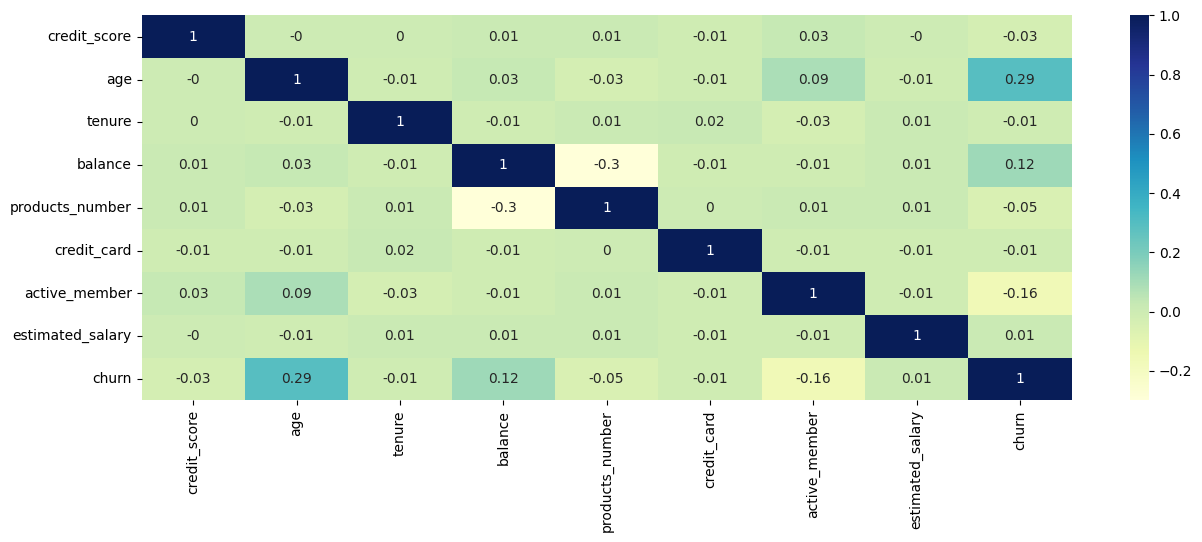

In [10]:
cor = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(round(cor,2), cmap="YlGnBu", annot=True);

In [11]:
dfstat2 = df.copy()
dfstat2 = dfstat2.describe().transpose()
dfstat2['Median'] = list(df.median(numeric_only=True))
dfstat2

count           mean           std     min       25%  \
credit_score      10000.0     650.528800     96.653299  350.00    584.00   
age               10000.0      38.921800     10.487806   18.00     32.00   
tenure            10000.0       5.012800      2.892174    0.00      3.00   
balance           10000.0   76485.889288  62397.405202    0.00      0.00   
products_number   10000.0       1.530200      0.581654    1.00      1.00   
credit_card       10000.0       0.705500      0.455840    0.00      0.00   
active_member     10000.0       0.515100      0.499797    0.00      0.00   
estimated_salary  10000.0  100090.239881  57510.492818   11.58  51002.11   
churn             10000.0       0.203700      0.402769    0.00      0.00   

                         50%          75%        max      Median  
credit_score         652.000     718.0000     850.00     652.000  
age                   37.000      44.0000      92.00      37.000  
tenure                 5.000       7.0000      10.00       5.000  
balance            97198.540  127644.2400  250898.09   97198.540  
products_number        1.000       2.0000       4.00       1.000  
credit_card            1.000       1.0000       1.00       1.000  
active_member          1.000       1.0000       1.00       1.000  
estimated_salary  100193.915  149388.2475  199992.48  100193.915  
churn                  0.000       0.0000       1.00       0.000

array([[<Axes: title={'center': 'credit_score'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'products_number'}>,
        <Axes: title={'center': 'credit_card'}>],
       [<Axes: title={'center': 'active_member'}>,
        <Axes: title={'center': 'estimated_salary'}>,
        <Axes: title={'center': 'churn'}>]], dtype=object)

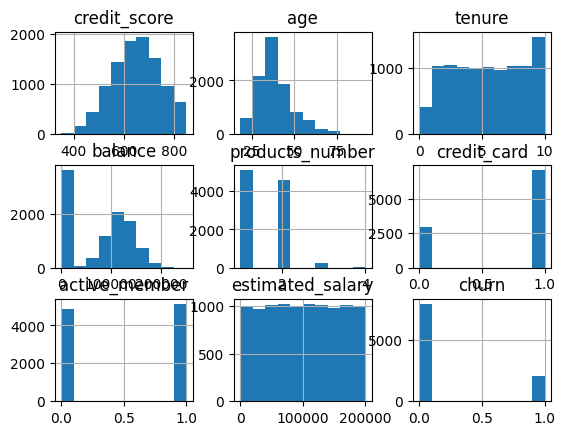

In [12]:
df.hist()

<Axes: >

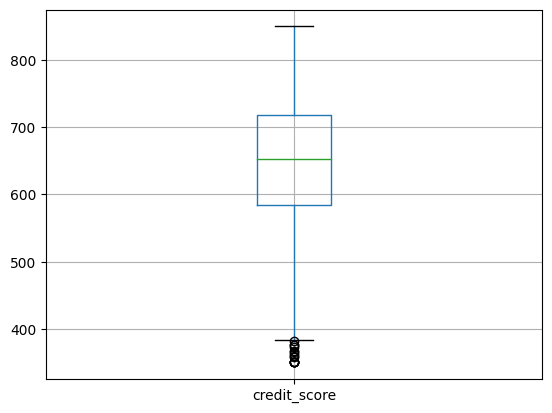

In [13]:
df.boxplot('credit_score')

<Axes: >

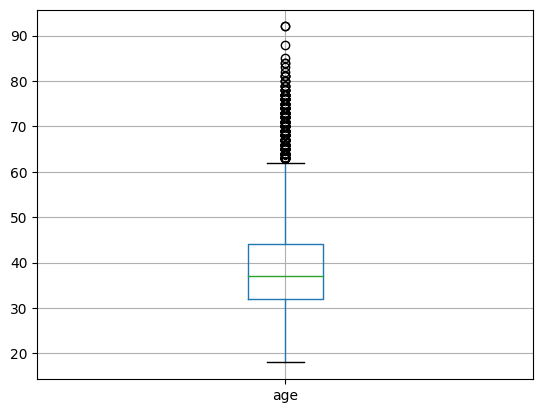

In [14]:
df.boxplot('age')

In [15]:
df = df.drop(columns = 'customer_id')

In [16]:
dfsupernew = pd.get_dummies (df)

<Axes: xlabel='churn'>

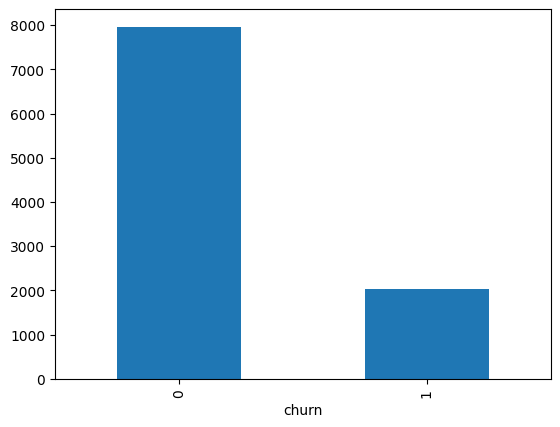

In [17]:
df['churn'].value_counts().plot(kind='bar')

In [18]:
dfsupernew.head()

credit_score  age  tenure    balance  products_number  credit_card  \
0           619   42       2       0.00                1            1   
1           608   41       1   83807.86                1            0   
2           502   42       8  159660.80                3            1   
3           699   39       1       0.00                2            0   
4           850   43       2  125510.82                1            1   

   active_member  estimated_salary  churn  country_France  country_Germany  \
0              1         101348.88      1            True            False   
1              1         112542.58      0           False            False   
2              0         113931.57      1            True            False   
3              0          93826.63      0            True            False   
4              1          79084.10      0           False            False   

   country_Spain  gender_Female  gender_Male  
0          False           True        False  
1           True           True        False  
2          False           True        False  
3          False           True        False  
4           True           True        False

In [19]:
dfsupernew.dtypes

credit_score          int64
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
country_France         bool
country_Germany        bool
country_Spain          bool
gender_Female          bool
gender_Male            bool
dtype: object

In [20]:
sc= StandardScaler()
sc = sc.fit_transform(dfsupernew)
sc_df  = pd.DataFrame(sc, columns = dfsupernew.columns)
sc_df.shape

(10000, 14)

In [21]:
sc_df.dtypes

credit_score        float64
age                 float64
tenure              float64
balance             float64
products_number     float64
credit_card         float64
active_member       float64
estimated_salary    float64
churn               float64
country_France      float64
country_Germany     float64
country_Spain       float64
gender_Female       float64
gender_Male         float64
dtype: object

In [22]:
pca = PCA(n_components = 0.95)
pca.fit(sc_df)
finaldf = pca.transform(sc_df)

finaldf.shape

(10000, 11)

# Clustering algorithms

##K-means

Elbow Method or Silhouette Score

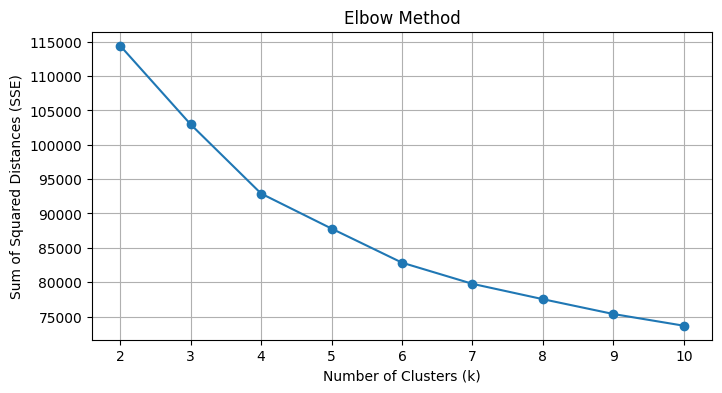

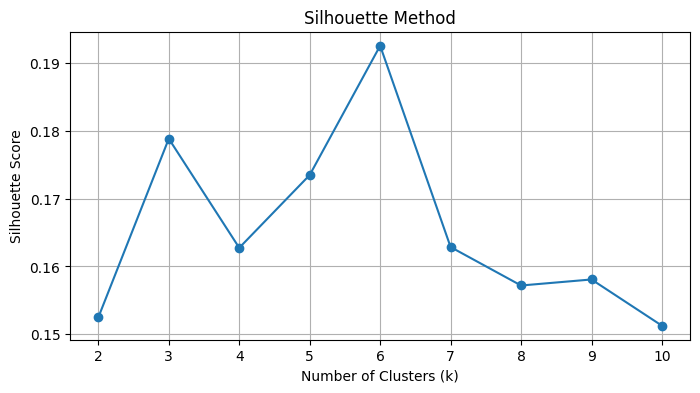

In [ ]:
k_values = range(2, 11)

sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(finaldf)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.grid(True)
plt.show()


silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(finaldf)
    silhouette_scores.append(silhouette_score(finaldf, kmeans.labels_))

plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

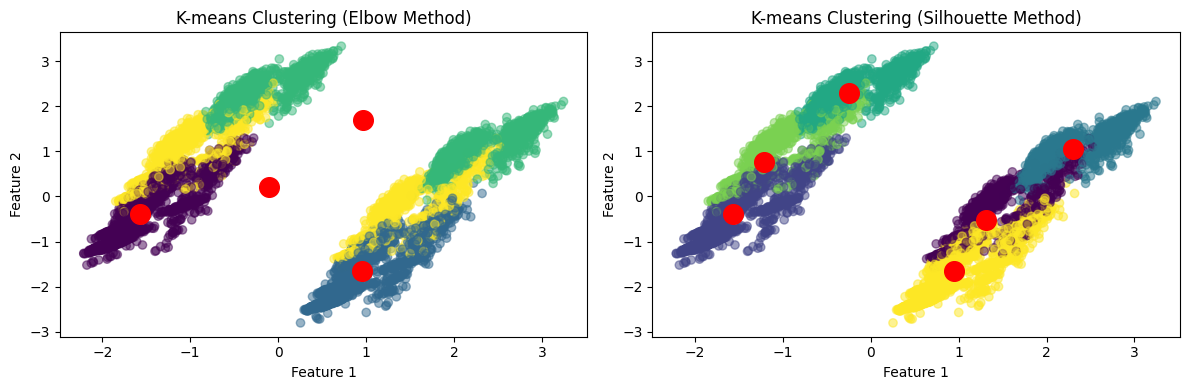

In [ ]:
optimal_k_elbow = 4
optimal_k_silhouette = 6

kmeans_elbow = KMeans(n_clusters=optimal_k_elbow)
kmeans_elbow.fit(finaldf)

kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette)
kmeans_silhouette.fit(finaldf)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.scatter(finaldf[:, 0], finaldf[:, 1], c=kmeans_elbow.labels_, cmap='viridis', alpha=0.5)
plt.scatter(kmeans_elbow.cluster_centers_[:, 0], kmeans_elbow.cluster_centers_[:, 1], marker='o', s=200, color='red')
plt.title('K-means Clustering (Elbow Method)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


plt.subplot(1, 2, 2)
plt.scatter(finaldf[:, 0], finaldf[:, 1], c=kmeans_silhouette.labels_, cmap='viridis', alpha=0.5)
plt.scatter(kmeans_silhouette.cluster_centers_[:, 0], kmeans_silhouette.cluster_centers_[:, 1], marker='o', s=200, color='red')
plt.title('K-means Clustering (Silhouette Method)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()


In [ ]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(optimal_k_elbow), colors):
    class_members = kmeans_elbow.labels_ == k
    cluster_center = kmeans_elbow.cluster_centers_[k]
    plt.plot(finaldf[class_members, 0], finaldf[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in finaldf[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % optimal_k_elbow)
plt.show()

plt.close('all')
plt.figure(2)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(optimal_k_silhouette), colors):
    class_members = kmeans_silhouette.labels_ == k
    cluster_center = kmeans_silhouette.cluster_centers_[k]
    plt.plot(finaldf[class_members, 0], finaldf[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in finaldf[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % optimal_k_silhouette)
plt.show()


##Hierarchical Clustering

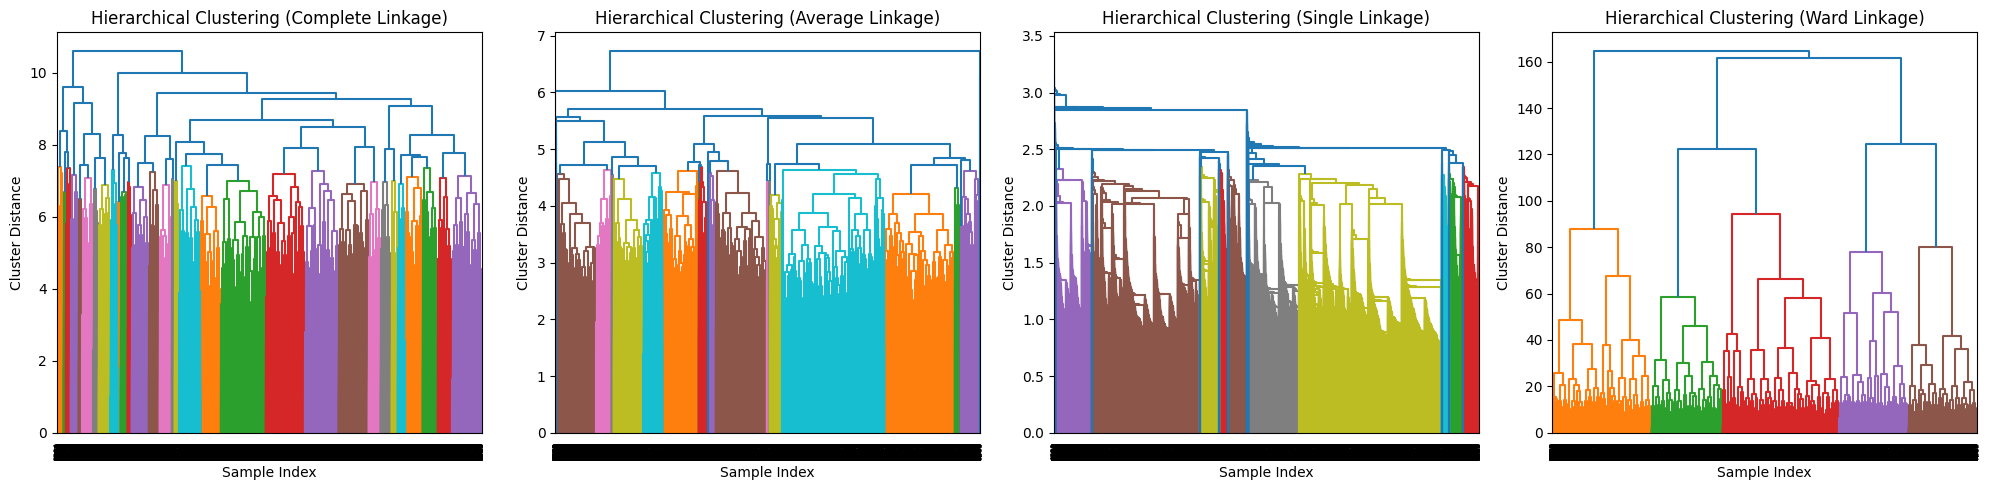

In [ ]:
x = finaldf

linked_complete = linkage(x, method='complete')
linked_average = linkage(x, method='average')
linked_single = linkage(x, method='single')
linked_ward =  linkage(x, method='ward')

plt.figure(figsize=(20, 5))


plt.subplot(1, 4, 1)
sch.dendrogram(linked_complete)
plt.title('Hierarchical Clustering (Complete Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')


plt.subplot(1, 4, 2)
sch.dendrogram(linked_average)
plt.title('Hierarchical Clustering (Average Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')


plt.subplot(1, 4, 3)
sch.dendrogram(linked_single)
plt.title('Hierarchical Clustering (Single Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')


plt.subplot(1, 4, 4)
sch.dendrogram(linked_ward)
plt.title('Hierarchical Clustering (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Cluster Distance')


plt.tight_layout()
plt.show()


##DBSCAN

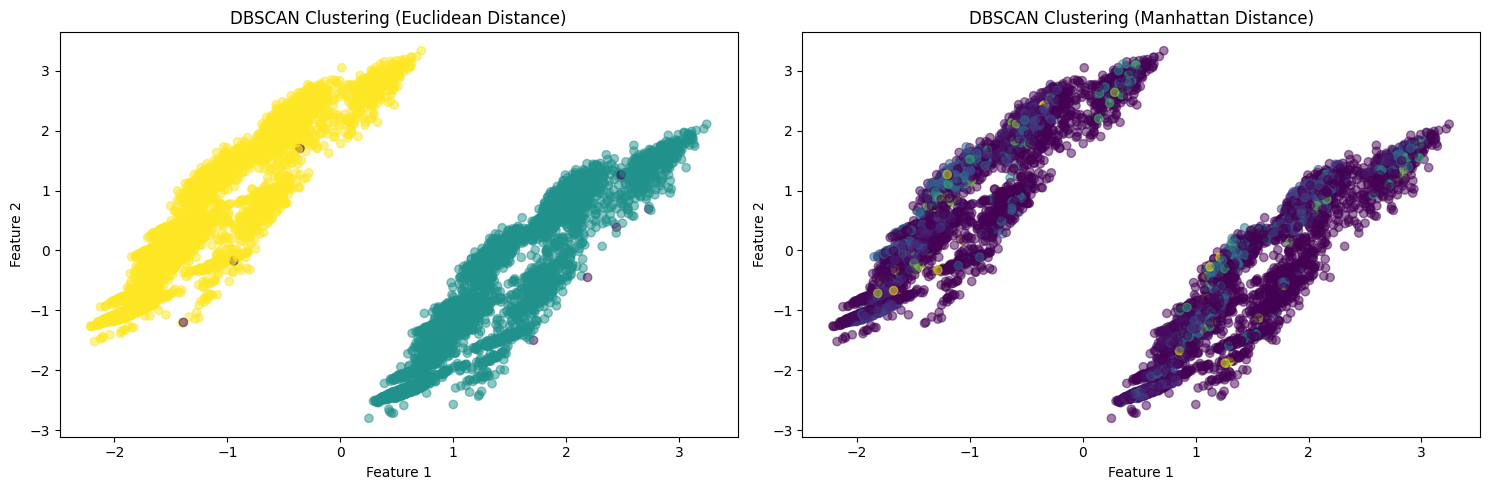

In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(finaldf)
distances, _ = nn.kneighbors()
eps = np.sort(distances[:, -1])[int(0.99 * len(distances))]


dbscan_euclidean = DBSCAN(eps=eps, min_samples=5, metric='euclidean', n_jobs=-1)
labels_euclidean_dbscan = dbscan_euclidean.fit_predict(finaldf)


dbscan_manhattan = DBSCAN(eps=eps, min_samples=5, metric='manhattan', n_jobs=-1)
labels_manhattan_dbscan = dbscan_manhattan.fit_predict(finaldf)


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(finaldf[:, 0], finaldf[:, 1], c=labels_euclidean_dbscan, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering (Euclidean Distance)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(finaldf[:, 0], finaldf[:, 1], c=labels_manhattan_dbscan, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering (Manhattan Distance)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')


plt.tight_layout()
plt.show()

##Gaussian Mixture Model

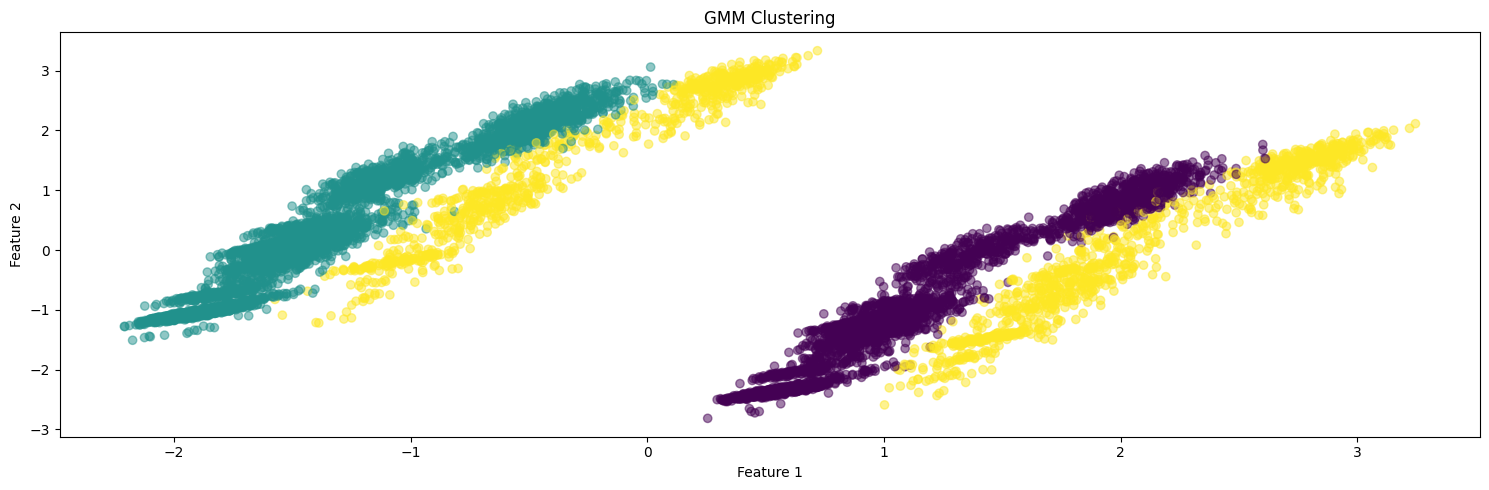

In [ ]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42, n_init=10)
labels_gmm = gmm.fit_predict(finaldf)

plt.figure(figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.scatter(finaldf[:, 0], finaldf[:, 1], c=labels_gmm, cmap='viridis', alpha=0.5)
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()


##Evaluation Metrics

In [ ]:
kmeans_elbow_silhouette = silhouette_score(finaldf, kmeans_elbow.labels_)
kmeans_elbow_db = davies_bouldin_score(finaldf, kmeans_elbow.labels_)
kmeans_elbow_ch = calinski_harabasz_score(finaldf, kmeans_elbow.labels_)

kmeans_silhouette_silhouette = silhouette_score(finaldf, kmeans_silhouette.labels_)
kmeans_silhouette_db = davies_bouldin_score(finaldf, kmeans_silhouette.labels_)
kmeans_silhouette_ch = calinski_harabasz_score(finaldf, kmeans_silhouette.labels_)


hierarchical_labels_complete = sch.fcluster(linked_complete, 6, criterion='maxclust')
hierarchical_silhouette_complete = silhouette_score(finaldf, hierarchical_labels_complete)
hierarchical_db_complete = davies_bouldin_score(finaldf, hierarchical_labels_complete)
hierarchical_ch_complete = calinski_harabasz_score(finaldf, hierarchical_labels_complete)

hierarchical_labels_single = sch.fcluster(linked_single, 6, criterion='maxclust')
hierarchical_silhouette_single = silhouette_score(finaldf, hierarchical_labels_single)
hierarchical_db_single = davies_bouldin_score(finaldf, hierarchical_labels_single)
hierarchical_ch_single = calinski_harabasz_score(finaldf, hierarchical_labels_single)

hierarchical_labels_average = sch.fcluster(linked_average, 6, criterion='maxclust')
hierarchical_silhouette_average = silhouette_score(finaldf, hierarchical_labels_average)
hierarchical_db_average = davies_bouldin_score(finaldf, hierarchical_labels_average)
hierarchical_ch_average = calinski_harabasz_score(finaldf, hierarchical_labels_average)

hierarchical_labels_ward = sch.fcluster(linked_ward, 6, criterion='maxclust')
hierarchical_silhouette_ward = silhouette_score(finaldf, hierarchical_labels_ward)
hierarchical_db_ward = davies_bouldin_score(finaldf, hierarchical_labels_ward)
hierarchical_ch_ward = calinski_harabasz_score(finaldf, hierarchical_labels_ward)


dbscan_euclidean_silhouette = silhouette_score(finaldf, labels_euclidean_dbscan)
dbscan_euclidean_db = davies_bouldin_score(finaldf, labels_euclidean_dbscan)
dbscan_euclidean_ch = calinski_harabasz_score(finaldf, labels_euclidean_dbscan)

dbscan_manhattan_silhouette = silhouette_score(finaldf, labels_manhattan_dbscan)
dbscan_manhattan_db = davies_bouldin_score(finaldf, labels_manhattan_dbscan)
dbscan_manhattan_ch = calinski_harabasz_score(finaldf, labels_manhattan_dbscan)


gmm_silhouette = silhouette_score(finaldf, labels_gmm)
gmm_db = davies_bouldin_score(finaldf, labels_gmm)
gmm_ch = calinski_harabasz_score(finaldf, labels_gmm)



from tabulate import tabulate

results = pd.DataFrame({
    'Method': ['K-means (Elbow)', 'K-means (Silhouette)', 'Hierarchical (Complete)', 'Hierarchical (Single)', 'Hierarchical (Average)', 'Hierarchical (Ward)',
                'DBSCAN (Euclidean)', 'DBSCAN (Manhattan)', 'GMM'],
    'Silhouette Score': [kmeans_elbow_silhouette, kmeans_silhouette_silhouette, hierarchical_silhouette_complete,
                         hierarchical_silhouette_single, hierarchical_silhouette_average, hierarchical_silhouette_ward, dbscan_euclidean_silhouette,
                         dbscan_manhattan_silhouette,  gmm_silhouette],
    'Davies-Bouldin Score': [kmeans_elbow_db, kmeans_silhouette_db, hierarchical_db_complete, hierarchical_db_single,
                              hierarchical_db_average, hierarchical_db_ward, dbscan_euclidean_db, dbscan_manhattan_db ,
                              gmm_db],
    'Calinski-Harabasz Score': [kmeans_elbow_ch, kmeans_silhouette_ch, hierarchical_ch_complete, hierarchical_ch_single,
                                 hierarchical_ch_average, hierarchical_ch_ward, dbscan_euclidean_ch, dbscan_manhattan_ch,
                                 gmm_ch]
})

print(tabulate(results, headers='keys', tablefmt='grid'))

+----+-------------------------+--------------------+------------------------+---------------------------+
|    | Method                  |   Silhouette Score |   Davies-Bouldin Score |   Calinski-Harabasz Score |
+====+=========================+====================+========================+===========================+
|  0 | K-means (Elbow)         |          0.162748  |                1.92485 |                 1494.55   |
+----+-------------------------+--------------------+------------------------+---------------------------+
|  1 | K-means (Silhouette)    |          0.192523  |                1.98018 |                 1248.16   |
+----+-------------------------+--------------------+------------------------+---------------------------+
|  2 | Hierarchical (Complete) |          0.101247  |                2.35751 |                  584.052  |
+----+-------------------------+--------------------+------------------------+---------------------------+
|  3 | Hierarchical (Single)   |     

In [ ]:
dflabel.head()

customer_id  credit_score  age  tenure    balance  products_number  credit_card  active_member  \
0     15634602           619   42       2       0.00                1            1              1   
1     15647311           608   41       1   83807.86                1            0              1   
2     15619304           502   42       8  159660.80                3            1              0   
3     15701354           699   39       1       0.00                2            0              0   
4     15737888           850   43       2  125510.82                1            1              1   

   estimated_salary  churn  country_France  country_Germany  country_Spain  gender_Female  \
0         101348.88      1            True            False          False           True   
1         112542.58      0           False            False           True           True   
2         113931.57      1            True            False          False           True   
3          93826.63      0            True            False          False           True   
4          79084.10      0           False            False           True           True   

   gender_Male  Cluster  
0        False        0  
1        False        3  
2        False        0  
3        False        0  
4        False        3

##K-means (Silhouette) clusters

In [ ]:
dflabel = dfsupernew.copy()
dflabel['Cluster'] = kmeans_silhouette.labels_

df_m = pd.DataFrame({'features': list(dflabel)})
df_m['1 mean'] = list(dflabel.loc[dflabel['Cluster'] == 0].mean())
df_m['1 median'] = list(dflabel.loc[dflabel['Cluster'] == 0].median())
df_m['2 mean'] = list(dflabel.loc[dflabel['Cluster'] == 1].mean())
df_m['2 median'] = list(dflabel.loc[dflabel['Cluster'] == 1].median())
df_m['3 mean'] = list(dflabel.loc[dflabel['Cluster'] == 2].mean())
df_m['3 median'] = list(dflabel.loc[dflabel['Cluster'] == 2].median())
df_m['4 mean'] = list(dflabel.loc[dflabel['Cluster'] == 3].mean())
df_m['4 median'] = list(dflabel.loc[dflabel['Cluster'] == 3].median())
df_m['5 mean'] = list(dflabel.loc[dflabel['Cluster'] == 4].mean())
df_m['5 median'] = list(dflabel.loc[dflabel['Cluster'] == 4].median())
df_m['6 mean'] = list(dflabel.loc[dflabel['Cluster'] == 5].mean())
df_m['6 median'] = list(dflabel.loc[dflabel['Cluster'] == 5].median())


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
pd.set_option('display.colheader_justify', 'right')
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.3f}'.format

print(df_m)


            features     1 mean   1 median     2 mean  2 median     3 mean   3 median     4 mean   4 median    5 mean  5 median    6 mean  6 median
0       credit_score    651.770    653.000    650.065   653.000    653.094    651.000    649.967    650.500   650.992   650.000   649.186   652.000
1                age     39.199     38.000     38.296    37.000     40.154     39.000     39.425     38.000    38.649    37.000    38.774    37.000
2             tenure      5.000      5.000      5.049     5.000      4.966      5.000      5.050      5.000     5.058     5.000     4.950     5.000
3            balance  59862.093      0.000  63546.285 69413.440 119145.966 118907.600 120259.668 120120.490 63352.834 69857.005 60322.670 47536.400
4    products_number      1.573      2.000      1.517     1.000      1.511      1.000      1.527      1.000     1.513     1.000     1.548     2.000
5        credit_card      0.708      1.000      0.714     1.000      0.707      1.000      0.720      1.000     

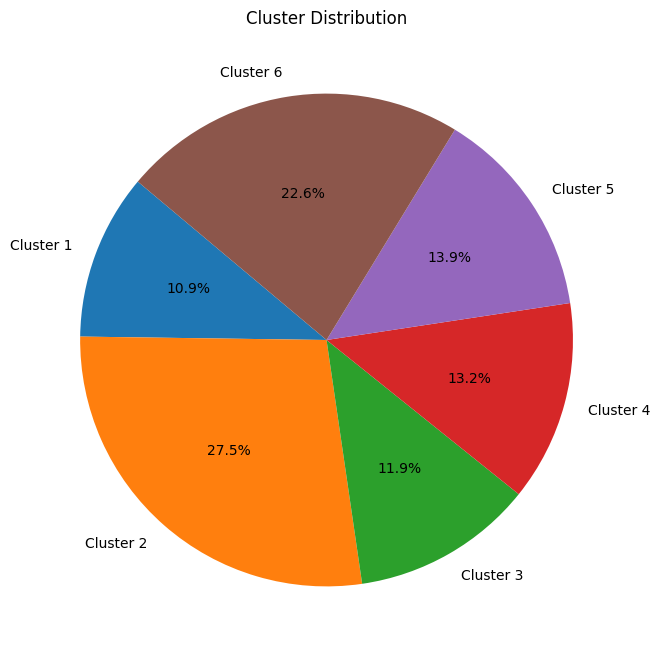

In [ ]:
import matplotlib.pyplot as plt


cluster_counts = dflabel['Cluster'].value_counts().sort_index()


plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=[f'Cluster {i+1}' for i in range(len(cluster_counts))], autopct='%1.1f%%', startangle=140)
plt.title('Cluster Distribution')
plt.show()


##RFM

In [ ]:
df = dfsupernew.copy()
df = df.drop_duplicates()

rfmtable = pd.DataFrame()
import pandas as pd


rfmtable['R'] = df['tenure']
rfmtable['F'] = df['products_number']
rfmtable['M'] = df['balance']


rfmtable["R_score"] = pd.qcut(rfmtable['R'], 4, labels=[ 4, 3, 2, 1])
rfmtable["F_score"] = pd.qcut(rfmtable['F'].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfmtable["M_score"] = pd.qcut(rfmtable['M'], 4, labels=[1, 2, 3], duplicates='drop')


rfmtable['score'] = rfmtable['R_score'].astype(int) + rfmtable['F_score'].astype(int) + rfmtable['M_score'].astype(int)

def rfm_scores(score):
    if score > 7:
        return '1'
    elif score > 5:
        return '2'
    else:
        return '3'


rfmtable['Cluster'] = rfmtable['score'].apply(lambda score : rfm_scores(score))


rfmtable.head()

R  F          M R_score F_score M_score  score Cluster
0  2  1       0.00       4       1       1      6       2
1  1  1   83807.86       4       1       1      6       2
2  8  3  159660.80       1       4       3      8       1
3  1  2       0.00       4       3       1      8       1
4  2  1  125510.82       4       1       2      7       2

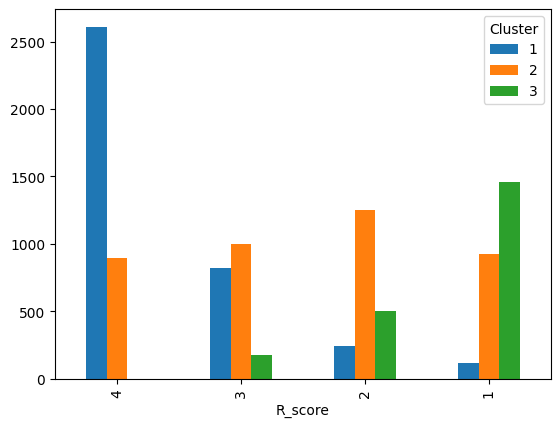

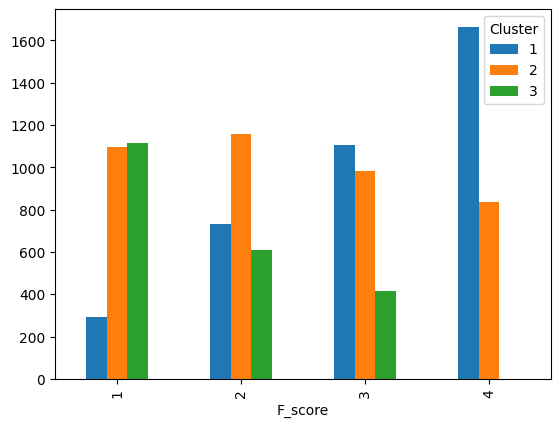

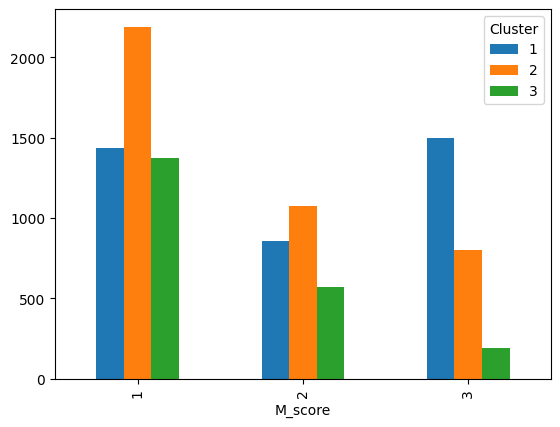

In [ ]:
crosstb1=pd.crosstab(rfmtable['R_score'], rfmtable['Cluster'])
barplot1 = crosstb1.plot.bar()
crosstb2=pd.crosstab(rfmtable['F_score'], rfmtable['Cluster'])
barplot2 = crosstb2.plot.bar()
crosstb3=pd.crosstab(rfmtable['M_score'], rfmtable['Cluster'])
barplot3 = crosstb3.plot.bar()

In [ ]:
from collections import Counter
c = Counter(list(rfmtable['Cluster']))
c

Counter({'2': 4068, '1': 3795, '3': 2137})

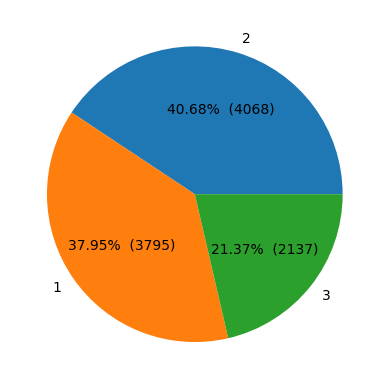

In [ ]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

pr1 = list(c.values())
pr2 = list(c.keys())
plt.pie(pr1, labels=pr2, autopct=make_autopct(pr1))
plt.show()

In [ ]:
df.head()

credit_score  age  tenure    balance  products_number  credit_card  \
0           619   42       2       0.00                1            1   
1           608   41       1   83807.86                1            0   
2           502   42       8  159660.80                3            1   
3           699   39       1       0.00                2            0   
4           850   43       2  125510.82                1            1   

   active_member  estimated_salary  churn  country_France  country_Germany  \
0              1         101348.88      1            True            False   
1              1         112542.58      0           False            False   
2              0         113931.57      1            True            False   
3              0          93826.63      0            True            False   
4              1          79084.10      0           False            False   

   country_Spain  gender_Female  gender_Male Cluster  
0          False           True        False       2  
1           True           True        False       2  
2          False           True        False       1  
3          False           True        False       1  
4           True           True        False       2

In [ ]:
dfm = dfsupernew.copy()
dfm['Cluster'] = rfmtable['Cluster']
df = pd.DataFrame({'features': list(dfm)})
df['1 mean'] = list(dfm.loc[dfm['Cluster'] == '1'].mean())
df['1 median'] = list(dfm.loc[dfm['Cluster'] == '1'].median())
df['2 mean'] = list(dfm.loc[dfm['Cluster'] == '2'].mean())
df['2 median'] = list(dfm.loc[dfm['Cluster'] == '2'].median())
df['3 mean'] = list(dfm.loc[dfm['Cluster'] == '3'].mean())
df['3 median'] = list(dfm.loc[dfm['Cluster'] == '3'].median())

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
pd.set_option('display.colheader_justify', 'right')
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.3f}'.format

print(df)

            features    1 mean   1 median     2 mean   2 median    3 mean  3 median
0       credit_score   651.700    652.000    649.047    650.000   651.270   654.000
1                age    38.715     37.000     38.838     37.000    39.448    38.000
2             tenure     2.890      3.000      5.486      6.000     7.882     8.000
3            balance 89663.453 114321.280  71096.935  90429.035 63342.891 79656.810
4    products_number     1.794      2.000      1.463      1.000     1.191     1.000
5        credit_card     0.699      1.000      0.705      1.000     0.720     1.000
6      active_member     0.526      1.000      0.515      1.000     0.496     0.000
7   estimated_salary 99496.003  98896.060 101184.447 101670.465 99062.581 99449.860
8              churn     0.189      0.000      0.198      0.000     0.240     0.000
9     country_France     0.465      0.000      0.524      1.000     0.524     1.000
10   country_Germany     0.305      0.000      0.229      0.000     0.197   

#Churn Prediction

In [23]:
dfw = dfsupernew.copy()

In [ ]:
churn_counts = dfw['churn'].value_counts()
print("Churn Value Counts:")
print(churn_counts)

Churn Value Counts:
churn
0    7963
1    2037
Name: count, dtype: int64


In [24]:
dfw['country_France'] = dfw['country_France'].astype('int64')
dfw['country_Germany'] = dfw['country_Germany'].astype('int64')
dfw['country_Spain'] = dfw['country_Spain'].astype('int64')
dfw['gender_Female'] = dfw['gender_Female'].astype('int64')
dfw['gender_Male'] = dfw['gender_Male'].astype('int64')
dfw.head()

credit_score  age  tenure    balance  products_number  credit_card  \
0           619   42       2       0.00                1            1   
1           608   41       1   83807.86                1            0   
2           502   42       8  159660.80                3            1   
3           699   39       1       0.00                2            0   
4           850   43       2  125510.82                1            1   

   active_member  estimated_salary  churn  country_France  country_Germany  \
0              1         101348.88      1               1                0   
1              1         112542.58      0               0                0   
2              0         113931.57      1               1                0   
3              0          93826.63      0               1                0   
4              1          79084.10      0               0                0   

   country_Spain  gender_Female  gender_Male  
0              0              1            0  
1              1              1            0  
2              0              1            0  
3              0              1            0  
4              1              1            0

In [ ]:
dfw.dtypes

##Hyperparameters tuning

### Optuna

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Bagging": BaggingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "MLPClassifier": MLPClassifier()
}


def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'SVM', 'KNeighbors', 'XGBoost', 'CatBoost', 'MLPClassifier'])
    if classifier_name == 'LogisticRegression':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        classifier = LogisticRegression(C=C)
    elif classifier_name == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 1, 32)
        classifier = DecisionTreeClassifier(max_depth=max_depth)
    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        classifier = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
    elif classifier_name == 'SVM':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        classifier = SVC(C=C)
    elif classifier_name == 'KNeighbors':
        n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif classifier_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 1, 32)
        learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.2)
        classifier = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('iterations', 50, 300)
        depth = trial.suggest_int('depth', 1, 12)
        classifier = CatBoostClassifier(iterations=iterations, depth=depth, verbose=False)
    elif classifier_name == 'MLPClassifier':
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (100, 50)])
        classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)

    score = cross_val_score(classifier, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print(f"Best params: {best_trial.params}")


[I 2024-05-16 00:24:46,092] A new study created in memory with name: no-name-f8f3121a-73b6-4a7f-9423-d287e6ba9320
[I 2024-05-16 00:24:47,639] Trial 0 finished with value: 0.8209999162707812 and parameters: {'classifier': 'KNeighbors', 'n_neighbors': 33}. Best is trial 0 with value: 0.8209999162707812.
[I 2024-05-16 00:24:53,177] Trial 1 finished with value: 0.8619998081635144 and parameters: {'classifier': 'RandomForest', 'n_estimators': 253, 'max_depth': 15}. Best is trial 1 with value: 0.8619998081635144.
[I 2024-05-16 00:24:55,796] Trial 2 finished with value: 0.8272498383313489 and parameters: {'classifier': 'KNeighbors', 'n_neighbors': 11}. Best is trial 1 with value: 0.8619998081635144.
[I 2024-05-16 00:24:55,934] Trial 3 finished with value: 0.8120009942493122 and parameters: {'classifier': 'LogisticRegression', 'C': 29.521186049980255}. Best is trial 1 with value: 0.8619998081635144.
[I 2024-05-16 00:25:40,617] Trial 4 finished with value: 0.8524999172552793 and parameters: {'c

Best trial: 0.86474923005217
Best params: {'classifier': 'CatBoost', 'iterations': 300, 'depth': 3}


### Random Search

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def make_pipeline(model):
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

models = {
    "LDA": make_pipeline(LDA()),
    "Logistic Regression": make_pipeline(LogisticRegression()),
    "Decision Tree": make_pipeline(DecisionTreeClassifier()),
    "Random Forest": make_pipeline(RandomForestClassifier()),
    "Gradient Boosting": make_pipeline(GradientBoostingClassifier()),
    "Bagging": make_pipeline(BaggingClassifier()),
    "SVM": make_pipeline(SVC()),
    "K-Nearest Neighbors": make_pipeline(KNeighborsClassifier()),
    "XGBoost": make_pipeline(XGBClassifier()),
    "CatBoost": make_pipeline(CatBoostClassifier(verbose=0)),
    "AdaBoost": make_pipeline(AdaBoostClassifier()),
    "MLPClassifier": make_pipeline(MLPClassifier()),
    "Balanced Random Forest": make_pipeline(BalancedRandomForestClassifier(n_estimators=100, random_state=42)),
    "LGBM": make_pipeline(lgb.LGBMClassifier())
}

param_distributions = {
   "LDA": {'classifier__solver': ['svd', 'lsqr', 'eigen'], 'classifier__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]},
    "Logistic Regression": {'classifier__C': uniform(0.1, 10)},
    "Decision Tree": {'classifier__max_depth': randint(3, 8)},
    "Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Gradient Boosting": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Bagging": {'classifier__n_estimators': randint(50, 200)},
    "SVM": {'classifier__C': uniform(0.1, 10)},
    "K-Nearest Neighbors": {'classifier__n_neighbors': randint(3, 8)},
    "XGBoost": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "CatBoost": {'classifier__iterations': randint(50, 200), 'classifier__depth': randint(3, 8)},
    "AdaBoost": {'classifier__n_estimators': randint(50, 200)},
    "MLPClassifier": {'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    "Balanced Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 10)},
    "LGBM": {'classifier__num_leaves': randint(31, 200), 'classifier__max_depth': randint(-1, 20), 'classifier__learning_rate': uniform(0.01, 0.3)}
}

results = {}
for name, pipeline in models.items():
    random_search = RandomizedSearchCV(pipeline, param_distributions[name], n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results[name] = {
        "Best Params": best_params,
        "Accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

results_df = pd.DataFrame(results).T
print("\nResults on Test Set:")
print(results_df)


[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
results

{'LDA': {'Best Params': {'classifier__solver': 'svd',
   'classifier__shrinkage': None},
  'Accuracy': 0.8085,
  'precision': 0.5301204819277109,
  'recall': 0.22391857506361323,
  'f1': 0.3148479427549195,
  'roc_auc': 0.5876904636363492},
 'Logistic Regression': {'Best Params': {'classifier__C': 3.845401188473625},
  'Accuracy': 0.811,
  'precision': 0.5524475524475524,
  'recall': 0.2010178117048346,
  'f1': 0.2947761194029851,
  'roc_auc': 0.5805960247074267},
 'Decision Tree': {'Best Params': {'classifier__max_depth': 6},
  'Accuracy': 0.86,
  'precision': 0.7325102880658436,
  'recall': 0.4529262086513995,
  'f1': 0.559748427672956,
  'roc_auc': 0.7062390844128186},
 'Random Forest': {'Best Params': {'classifier__max_depth': 7,
   'classifier__n_estimators': 70},
  'Accuracy': 0.859,
  'precision': 0.7967914438502673,
  'recall': 0.3791348600508906,
  'f1': 0.5137931034482758,
  'roc_auc': 0.6777441568456071},
 'Gradient Boosting': {'Best Params': {'classifier__max_depth': 4,
   

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def make_pipeline(model):
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

models = {
    "LDA": make_pipeline(LDA()),
    "Logistic Regression": make_pipeline(LogisticRegression()),
    "Decision Tree": make_pipeline(DecisionTreeClassifier()),
    "Random Forest": make_pipeline(RandomForestClassifier()),
    "Gradient Boosting": make_pipeline(GradientBoostingClassifier()),
    "Bagging": make_pipeline(BaggingClassifier()),
    "SVM": make_pipeline(SVC()),
    "K-Nearest Neighbors": make_pipeline(KNeighborsClassifier()),
    "XGBoost": make_pipeline(XGBClassifier()),
    "CatBoost": make_pipeline(CatBoostClassifier(verbose=0)),
    "AdaBoost": make_pipeline(AdaBoostClassifier()),
    "MLPClassifier": make_pipeline(MLPClassifier()),
    "Balanced Random Forest": make_pipeline(BalancedRandomForestClassifier(n_estimators=100, random_state=42)),
    "LGBM": make_pipeline(lgb.LGBMClassifier())
}

param_distributions = {
   "LDA": {'classifier__solver': ['svd', 'lsqr', 'eigen'], 'classifier__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]},
    "Logistic Regression": {'classifier__C': uniform(0.1, 10)},
    "Decision Tree": {'classifier__max_depth': randint(3, 8)},
    "Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Gradient Boosting": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Bagging": {'classifier__n_estimators': randint(50, 200)},
    "SVM": {'classifier__C': uniform(0.1, 10)},
    "K-Nearest Neighbors": {'classifier__n_neighbors': randint(3, 8)},
    "XGBoost": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "CatBoost": {'classifier__iterations': randint(50, 200), 'classifier__depth': randint(3, 8)},
    "AdaBoost": {'classifier__n_estimators': randint(50, 200)},
    "MLPClassifier": {'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    "Balanced Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 10)},
    "LGBM": {'classifier__num_leaves': randint(31, 200), 'classifier__max_depth': randint(-1, 20), 'classifier__learning_rate': uniform(0.01, 0.3)}
}

results = {}
for name, pipeline in models.items():
    random_search = RandomizedSearchCV(pipeline, param_distributions[name], n_iter=5, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results[name] = {
        "Best Params": best_params,
        "Accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

results_df = pd.DataFrame(results).T
print("\nResults on Test Set:")
print(results_df)


[LightGBM] [Info] Number of positive: 6356, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def make_pipeline(model):
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('adasyn', ADASYN(random_state=42)),
        ('classifier', model)
    ])

models = {
    "LDA": make_pipeline(LDA()),
    "Logistic Regression": make_pipeline(LogisticRegression()),
    "Decision Tree": make_pipeline(DecisionTreeClassifier()),
    "Random Forest": make_pipeline(RandomForestClassifier()),
    "Gradient Boosting": make_pipeline(GradientBoostingClassifier()),
    "Bagging": make_pipeline(BaggingClassifier()),
    "SVM": make_pipeline(SVC()),
    "K-Nearest Neighbors": make_pipeline(KNeighborsClassifier()),
    "XGBoost": make_pipeline(XGBClassifier()),
    "CatBoost": make_pipeline(CatBoostClassifier(verbose=0)),
    "AdaBoost": make_pipeline(AdaBoostClassifier()),
    "MLPClassifier": make_pipeline(MLPClassifier()),
    "Balanced Random Forest": make_pipeline(BalancedRandomForestClassifier(n_estimators=100, random_state=42)),
    "LGBM": make_pipeline(lgb.LGBMClassifier())
}

param_distributions = {
   "LDA": {'classifier__solver': ['svd', 'lsqr', 'eigen'], 'classifier__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]},
    "Logistic Regression": {'classifier__C': uniform(0.1, 10)},
    "Decision Tree": {'classifier__max_depth': randint(3, 8)},
    "Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Gradient Boosting": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Bagging": {'classifier__n_estimators': randint(50, 200)},
    "SVM": {'classifier__C': uniform(0.1, 10)},
    "K-Nearest Neighbors": {'classifier__n_neighbors': randint(3, 8)},
    "XGBoost": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "CatBoost": {'classifier__iterations': randint(50, 200), 'classifier__depth': randint(3, 8)},
    "AdaBoost": {'classifier__n_estimators': randint(50, 200)},
    "MLPClassifier": {'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    "Balanced Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 10)},
    "LGBM": {'classifier__num_leaves': randint(31, 200), 'classifier__max_depth': randint(-1, 20), 'classifier__learning_rate': uniform(0.01, 0.3)}
}

results = {}
for name, pipeline in models.items():
    random_search = RandomizedSearchCV(pipeline, param_distributions[name], n_iter=5, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        "Best Params": best_params,
        "Accuracy": accuracy,
    }

results_df = pd.DataFrame(results).T
print("\nResults on Test Set:")
print(results_df)


[LightGBM] [Info] Number of positive: 5210, number of negative: 5084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1709
[LightGBM] [Info] Number of data points in the train set: 10294, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506120 -> initscore=0.024482
[LightGBM] [Info] Start training from score 0.024482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5250, number of negative: 5085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to 

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Initial class distribution:", np.bincount(y_train))

def make_pipeline(model):
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(sampling_strategy=0.4, random_state=42)),
        ('under', RandomUnderSampler(sampling_strategy=0.6, random_state=42)),
        ('classifier', model)
    ])


models = {
    "LDA": make_pipeline(LDA()),
    "Logistic Regression": make_pipeline(LogisticRegression()),
    "Decision Tree": make_pipeline(DecisionTreeClassifier()),
    "Random Forest": make_pipeline(RandomForestClassifier()),
    "Gradient Boosting": make_pipeline(GradientBoostingClassifier()),
    "Bagging": make_pipeline(BaggingClassifier()),
    "SVM": make_pipeline(SVC()),
    "K-Nearest Neighbors": make_pipeline(KNeighborsClassifier()),
    "XGBoost": make_pipeline(XGBClassifier()),
    "CatBoost": make_pipeline(CatBoostClassifier(verbose=0)),
    "AdaBoost": make_pipeline(AdaBoostClassifier()),
    "MLPClassifier": make_pipeline(MLPClassifier()),
    "Balanced Random Forest": make_pipeline(BalancedRandomForestClassifier(n_estimators=100, random_state=42)),
    "LGBM": make_pipeline(lgb.LGBMClassifier())
}

param_distributions = {
   "LDA": {'classifier__solver': ['svd', 'lsqr', 'eigen'], 'classifier__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]},
    "Logistic Regression": {'classifier__C': uniform(0.1, 10)},
    "Decision Tree": {'classifier__max_depth': randint(3, 8)},
    "Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Gradient Boosting": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "Bagging": {'classifier__n_estimators': randint(50, 200)},
    "SVM": {'classifier__C': uniform(0.1, 10)},
    "K-Nearest Neighbors": {'classifier__n_neighbors': randint(3, 8)},
    "XGBoost": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 8)},
    "CatBoost": {'classifier__iterations': randint(50, 200), 'classifier__depth': randint(3, 8)},
    "AdaBoost": {'classifier__n_estimators': randint(50, 200)},
    "MLPClassifier": {'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    "Balanced Random Forest": {'classifier__n_estimators': randint(50, 200), 'classifier__max_depth': randint(3, 10)},
    "LGBM": {'classifier__num_leaves': randint(31, 200), 'classifier__max_depth': randint(-1, 20), 'classifier__learning_rate': uniform(0.01, 0.3)}
}

results = {}
for name, pipeline in models.items():
    random_search = RandomizedSearchCV(pipeline, param_distributions[name], n_iter=5, cv=5, scoring='accuracy', random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        "Best Params": best_params,
        "Accuracy": accuracy,
    }

results_df = pd.DataFrame(results).T
print("\nResults on Test Set:")
print(results_df)


Initial class distribution: [6356 1644]

Results on Test Set:
                                                           Best Params  \
Logistic Regression               {'classifier__C': 3.845401188473625}   
Decision Tree                             {'classifier__max_depth': 6}   
Random Forest        {'classifier__max_depth': 6, 'classifier__n_es...   
Gradient Boosting    {'classifier__max_depth': 5, 'classifier__n_es...   
Bagging                              {'classifier__n_estimators': 121}   
SVM                              {'classifier__C': 1.6601864044243653}   
K-Nearest Neighbors                     {'classifier__n_neighbors': 6}   
XGBoost              {'classifier__max_depth': 4, 'classifier__n_es...   
CatBoost             {'classifier__depth': 4, 'classifier__iteratio...   
AdaBoost                             {'classifier__n_estimators': 142}   
MLPClassifier               {'classifier__hidden_layer_sizes': (100,)}   

                    Accuracy  
Logistic Regressio

### Bayesian Search

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
   "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Bagging": BaggingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "MLPClassifier": MLPClassifier()
}

param_spaces = {
    "Logistic Regression": {'C': Real(0.1, 10, prior='log-uniform')},
    "Decision Tree": {'max_depth': Integer(3, 7)},
   "Random Forest": {'n_estimators': Integer(50, 200), 'max_depth': Integer(3, 7)},
   "Gradient Boosting": {'n_estimators': Integer(50, 200), 'max_depth': Integer(3, 7)},
  "Bagging": {'n_estimators': Integer(50, 200)},
   "SVM": {'C': Real(0.1, 10, prior='log-uniform')},
  "K-Nearest Neighbors": {'n_neighbors': Integer(3, 7)},
  "XGBoost": {'n_estimators': Integer(50, 200), 'max_depth': Integer(3, 7)},
   "CatBoost": {'iterations': Integer(50, 200), 'depth': Integer(3, 7)},
  "MLPClassifier": {'hidden_layer_sizes': Categorical([(50,), (100,), (50, 50)])}
}
results_bayes = {}
for name, model in models.items():
    try:
        print(f"Starting Bayesian Optimization for {name}")
        bayes_search = BayesSearchCV(model, param_spaces[name], n_iter=10, cv=5, scoring='accuracy', random_state=42)
        bayes_search.fit(X_train_scaled, y_train)
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_
        print(f"Best Parameters for {name}: {best_params}")

        best_model.fit(X_train_scaled, y_train)
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {name}: {accuracy}")

        results_bayes[name] = {
            "Best Params": best_params,
            "Accuracy": accuracy
        }
    except Exception as e:
        print(f"Error with model {name}: {e}")
        continue

print("\nFinal results:")
for key, value in results_bayes.items():
    print(f"{key}: {value}")


Starting Bayesian Optimization for Logistic Regression
Best Parameters for Logistic Regression: OrderedDict([('C', 4.7290805470559185)])
Accuracy for Logistic Regression: 0.811
Starting Bayesian Optimization for Decision Tree
Best Parameters for Decision Tree: OrderedDict([('max_depth', 6)])
Accuracy for Decision Tree: 0.86
Starting Bayesian Optimization for Random Forest
Best Parameters for Random Forest: OrderedDict([('max_depth', 7), ('n_estimators', 155)])
Accuracy for Random Forest: 0.8565
Starting Bayesian Optimization for Gradient Boosting
Best Parameters for Gradient Boosting: OrderedDict([('max_depth', 3), ('n_estimators', 173)])
Accuracy for Gradient Boosting: 0.8655
Starting Bayesian Optimization for Bagging
Best Parameters for Bagging: OrderedDict([('n_estimators', 160)])
Accuracy for Bagging: 0.864
Starting Bayesian Optimization for SVM
Best Parameters for SVM: OrderedDict([('C', 2.9380287142759305)])
Accuracy for SVM: 0.8615
Starting Bayesian Optimization for K-Nearest Ne

### Gridsearch

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Bagging": BaggingClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

param_grids = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Decision Tree": {'max_depth': [3, 5, 7]},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    "Bagging": {'n_estimators': [50, 100, 200]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "K-Nearest Neighbors": {'n_neighbors': [3, 5, 7]},
    "XGBoost": {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]},
    "CatBoost": {'iterations': [50, 100, 200], 'depth': [3, 5, 7]}
}


best_params = {}
for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_train)
        best_params[name] = grid_search.best_params_
        print(f"Best parameters for {name}: {grid_search.best_params_}")

best_models = {}
for name, model in models.items():
        best_model = model.set_params(**best_params[name])
        best_model.fit(X_train_scaled, y_train)
        best_models[name] = best_model


results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc}


results_df = pd.DataFrame(results).T


print("\nResults on Test Set:")
print(results_df)

Best parameters for Logistic Regression: {'C': 10}
Best parameters for Decision Tree: {'max_depth': 5}
Best parameters for Random Forest: {'max_depth': 7, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'max_depth': 3, 'n_estimators': 100}
Best parameters for Bagging: {'n_estimators': 200}
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best parameters for K-Nearest Neighbors: {'n_neighbors': 7}
Best parameters for XGBoost: {'max_depth': 3, 'n_estimators': 50}
Best parameters for CatBoost: {'depth': 7, 'iterations': 200}

Results on Test Set:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression    0.8110   0.552448  0.201018  0.294776  0.580596
Decision Tree          0.8580   0.768473  0.396947  0.523490  0.683850
Random Forest          0.8575   0.784211  0.379135  0.511149  0.676811
Gradient Boosting      0.8645   0.742063  0.475827  0.579845  0.717689
Bagging                0.8625   0.706294  0.513995  0.594993  0.730862
SVM     

## Models' results

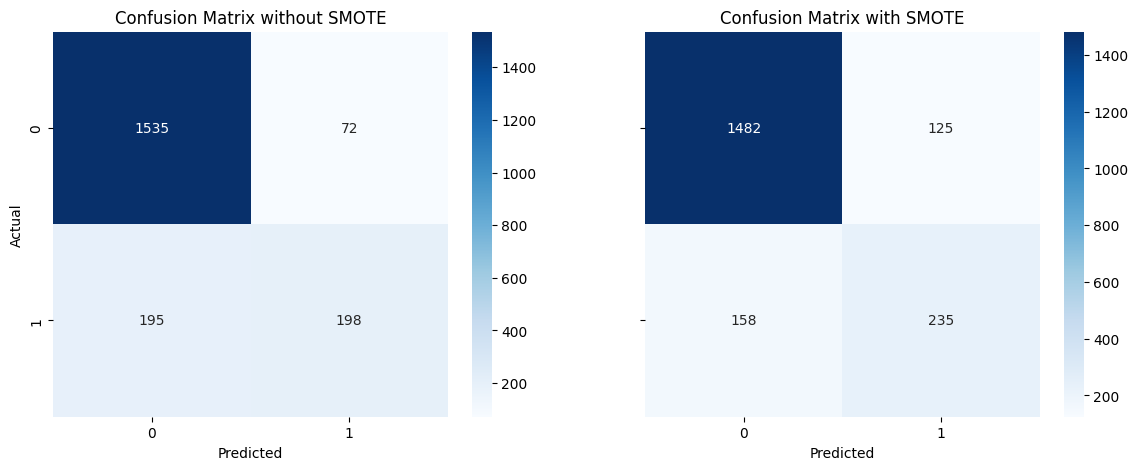

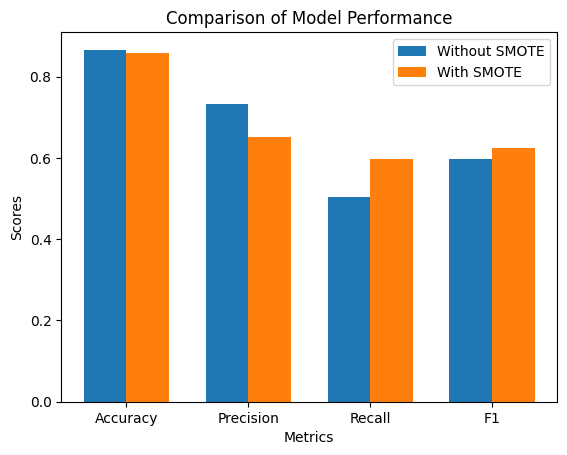

In [26]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_without_smote = CatBoostClassifier(verbose=0)
model_without_smote.fit(X_train, y_train)
y_pred_without = model_without_smote.predict(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model_with_smote = CatBoostClassifier(verbose=0)
model_with_smote.fit(X_train_smote, y_train_smote)
y_pred_with = model_with_smote.predict(X_test)

metrics_without_smote = {
    "Accuracy": accuracy_score(y_test, y_pred_without),
    "Precision": precision_score(y_test, y_pred_without),
    "Recall": recall_score(y_test, y_pred_without),
    "F1": f1_score(y_test, y_pred_without)
}

metrics_with_smote = {
    "Accuracy": accuracy_score(y_test, y_pred_with),
    "Precision": precision_score(y_test, y_pred_with),
    "Recall": recall_score(y_test, y_pred_with),
    "F1": f1_score(y_test, y_pred_with)
}

conf_matrix_without = confusion_matrix(y_test, y_pred_without)
conf_matrix_with = confusion_matrix(y_test, y_pred_with)

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.heatmap(conf_matrix_without, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('Confusion Matrix without SMOTE')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(conf_matrix_with, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title('Confusion Matrix with SMOTE')
ax[1].set_xlabel('Predicted')

plt.show()

fig, ax = plt.subplots()
x = np.arange(len(metrics_without_smote))
bar_width = 0.35

bars1 = ax.bar(x - bar_width/2, metrics_without_smote.values(), bar_width, label='Without SMOTE')
bars2 = ax.bar(x + bar_width/2, metrics_with_smote.values(), bar_width, label='With SMOTE')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics_without_smote.keys())
ax.legend()

plt.show()


In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return m, m - h, m + h

selected_models = {
    "Logistic Regression": LogisticRegression(C=3.845401188473625),
    "Decision Tree": DecisionTreeClassifier(max_depth=6),
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=70),
    "Gradient Boosting": GradientBoostingClassifier(max_depth=4, n_estimators=124),
    "Bagging": BaggingClassifier(n_estimators=121),
    "SVM": SVC(C=6.086584841970366),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(max_depth=4, n_estimators=124),
    "CatBoost": CatBoostClassifier(depth=6, iterations=142, verbose=0),
    "AdaBoost": AdaBoostClassifier(n_estimators=152),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,)),
    "Balanced Random Forest": RandomForestClassifier(max_depth=9, n_estimators=171) ,
    "LGBM": LGBMClassifier(classifier__learning_rate= 0.11011258334170654,classifier__max_depth=6,classifier__num_leaves= 182)
}

seeds = [42, 57, 71, 85, 99, 113, 127, 141, 155, 169]
results = {name: {'Accuracy': [], 'ROC AUC': []} for name in selected_models}
scaler = StandardScaler()

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in selected_models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results[name]['Accuracy'].append(accuracy)
        results[name]['ROC AUC'].append(roc_auc)

final_results = {}
for name, metrics in results.items():
    mean_acc, lower_acc, upper_acc = confidence_interval(metrics['Accuracy'])
    mean_auc, lower_auc, upper_auc = confidence_interval(metrics['ROC AUC'])
    final_results[name] = {
        "Mean Accuracy": mean_acc, "95% CI Accuracy Lower": lower_acc, "95% CI Accuracy Upper": upper_acc,
        "Mean ROC AUC": mean_auc, "95% CI ROC AUC Lower": lower_auc, "95% CI ROC AUC Upper": upper_auc
    }

results_df = pd.DataFrame(final_results).T
print("\nOverall Results:")
print(results_df)

[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
[LightGBM] [Warning] Unknown parameter: classifier__num_leaves
[

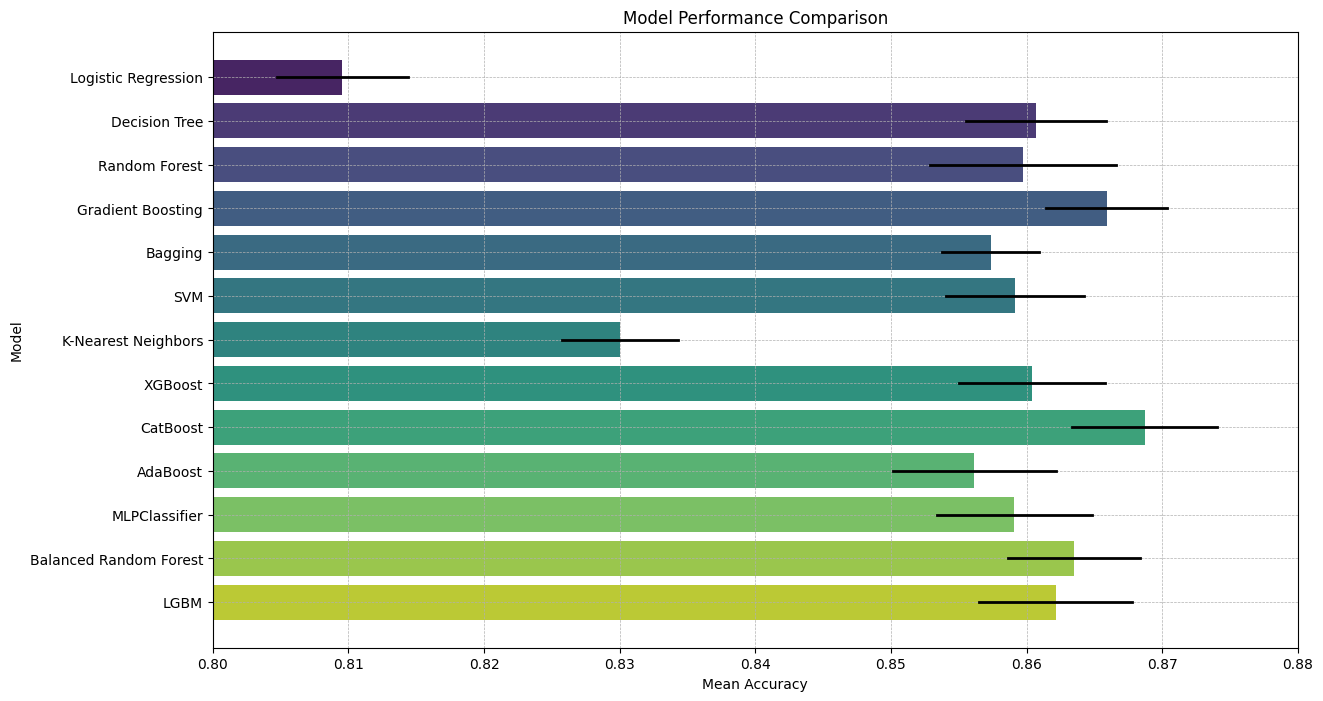

In [ ]:
results_df = results_df.reset_index().rename(columns={"index": "Model"})

plt.figure(figsize=(14, 8))
sns.barplot(x="Mean Accuracy", y="Model", data=results_df, ci=None, palette="viridis", orient='h')

for i in range(results_df.shape[0]):
    plt.plot([results_df["95% CI Lower"][i], results_df["95% CI Upper"][i]],
             [i, i], color='black', linestyle='-', lw=2)

plt.title('Model Performance Comparison')
plt.xlabel('Mean Accuracy')
plt.ylabel('Model')
plt.xlim(0.8, 0.88)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


## Feature importance

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {

    "CatBoost": CatBoostClassifier()
}

param_grids = {

    "CatBoost": {'iterations': [50, 100, 200], 'depth': [3, 5, 7]}
}

best_params = {}
for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids.get(name, {}), cv=5, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_train)
        best_params[name] = grid_search.best_params_
        print(f"Best parameters for {name}: {grid_search.best_params_}")

best_models = {}
for name, model in models.items():
        best_model = model.set_params(**best_params[name])
        best_model.fit(X_train_scaled, y_train)
        best_models[name] = best_model

results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    results[name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc}

results_df = pd.DataFrame(results).T


print("\nResults on Test Set:")
print(results_df)

from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=15)
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

Выходные данные были обрезаны до нескольких последних строк (5000).
41:	learn: 0.3311252	total: 118ms	remaining: 163ms
42:	learn: 0.3304921	total: 125ms	remaining: 166ms
43:	learn: 0.3302381	total: 128ms	remaining: 163ms
44:	learn: 0.3297266	total: 130ms	remaining: 159ms
45:	learn: 0.3292614	total: 142ms	remaining: 167ms
46:	learn: 0.3287267	total: 146ms	remaining: 165ms
47:	learn: 0.3284976	total: 151ms	remaining: 164ms
48:	learn: 0.3280203	total: 155ms	remaining: 161ms
49:	learn: 0.3273431	total: 157ms	remaining: 157ms
50:	learn: 0.3271634	total: 164ms	remaining: 157ms
51:	learn: 0.3269688	total: 167ms	remaining: 154ms
52:	learn: 0.3265504	total: 171ms	remaining: 152ms
53:	learn: 0.3263573	total: 173ms	remaining: 148ms
54:	learn: 0.3261169	total: 176ms	remaining: 144ms
55:	learn: 0.3256194	total: 178ms	remaining: 140ms
56:	learn: 0.3252804	total: 181ms	remaining: 136ms
57:	learn: 0.3250808	total: 183ms	remaining: 132ms
58:	learn: 0.3246936	total: 185ms	remaining: 128ms
59:	learn: 0.3

importances_mean  importances_std
balance                   0.118733         0.006218
products_number           0.044000         0.009274
country_Germany           0.033600         0.003870
country_Spain             0.001567         0.000964
tenure                    0.000867         0.003243
gender_Female             0.000367         0.000741
credit_score              0.000000         0.000000
age                       0.000000         0.000000
credit_card               0.000000         0.000000
active_member             0.000000         0.000000
estimated_salary          0.000000         0.000000
gender_Male               0.000000         0.000000
country_France           -0.011900         0.002538

[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

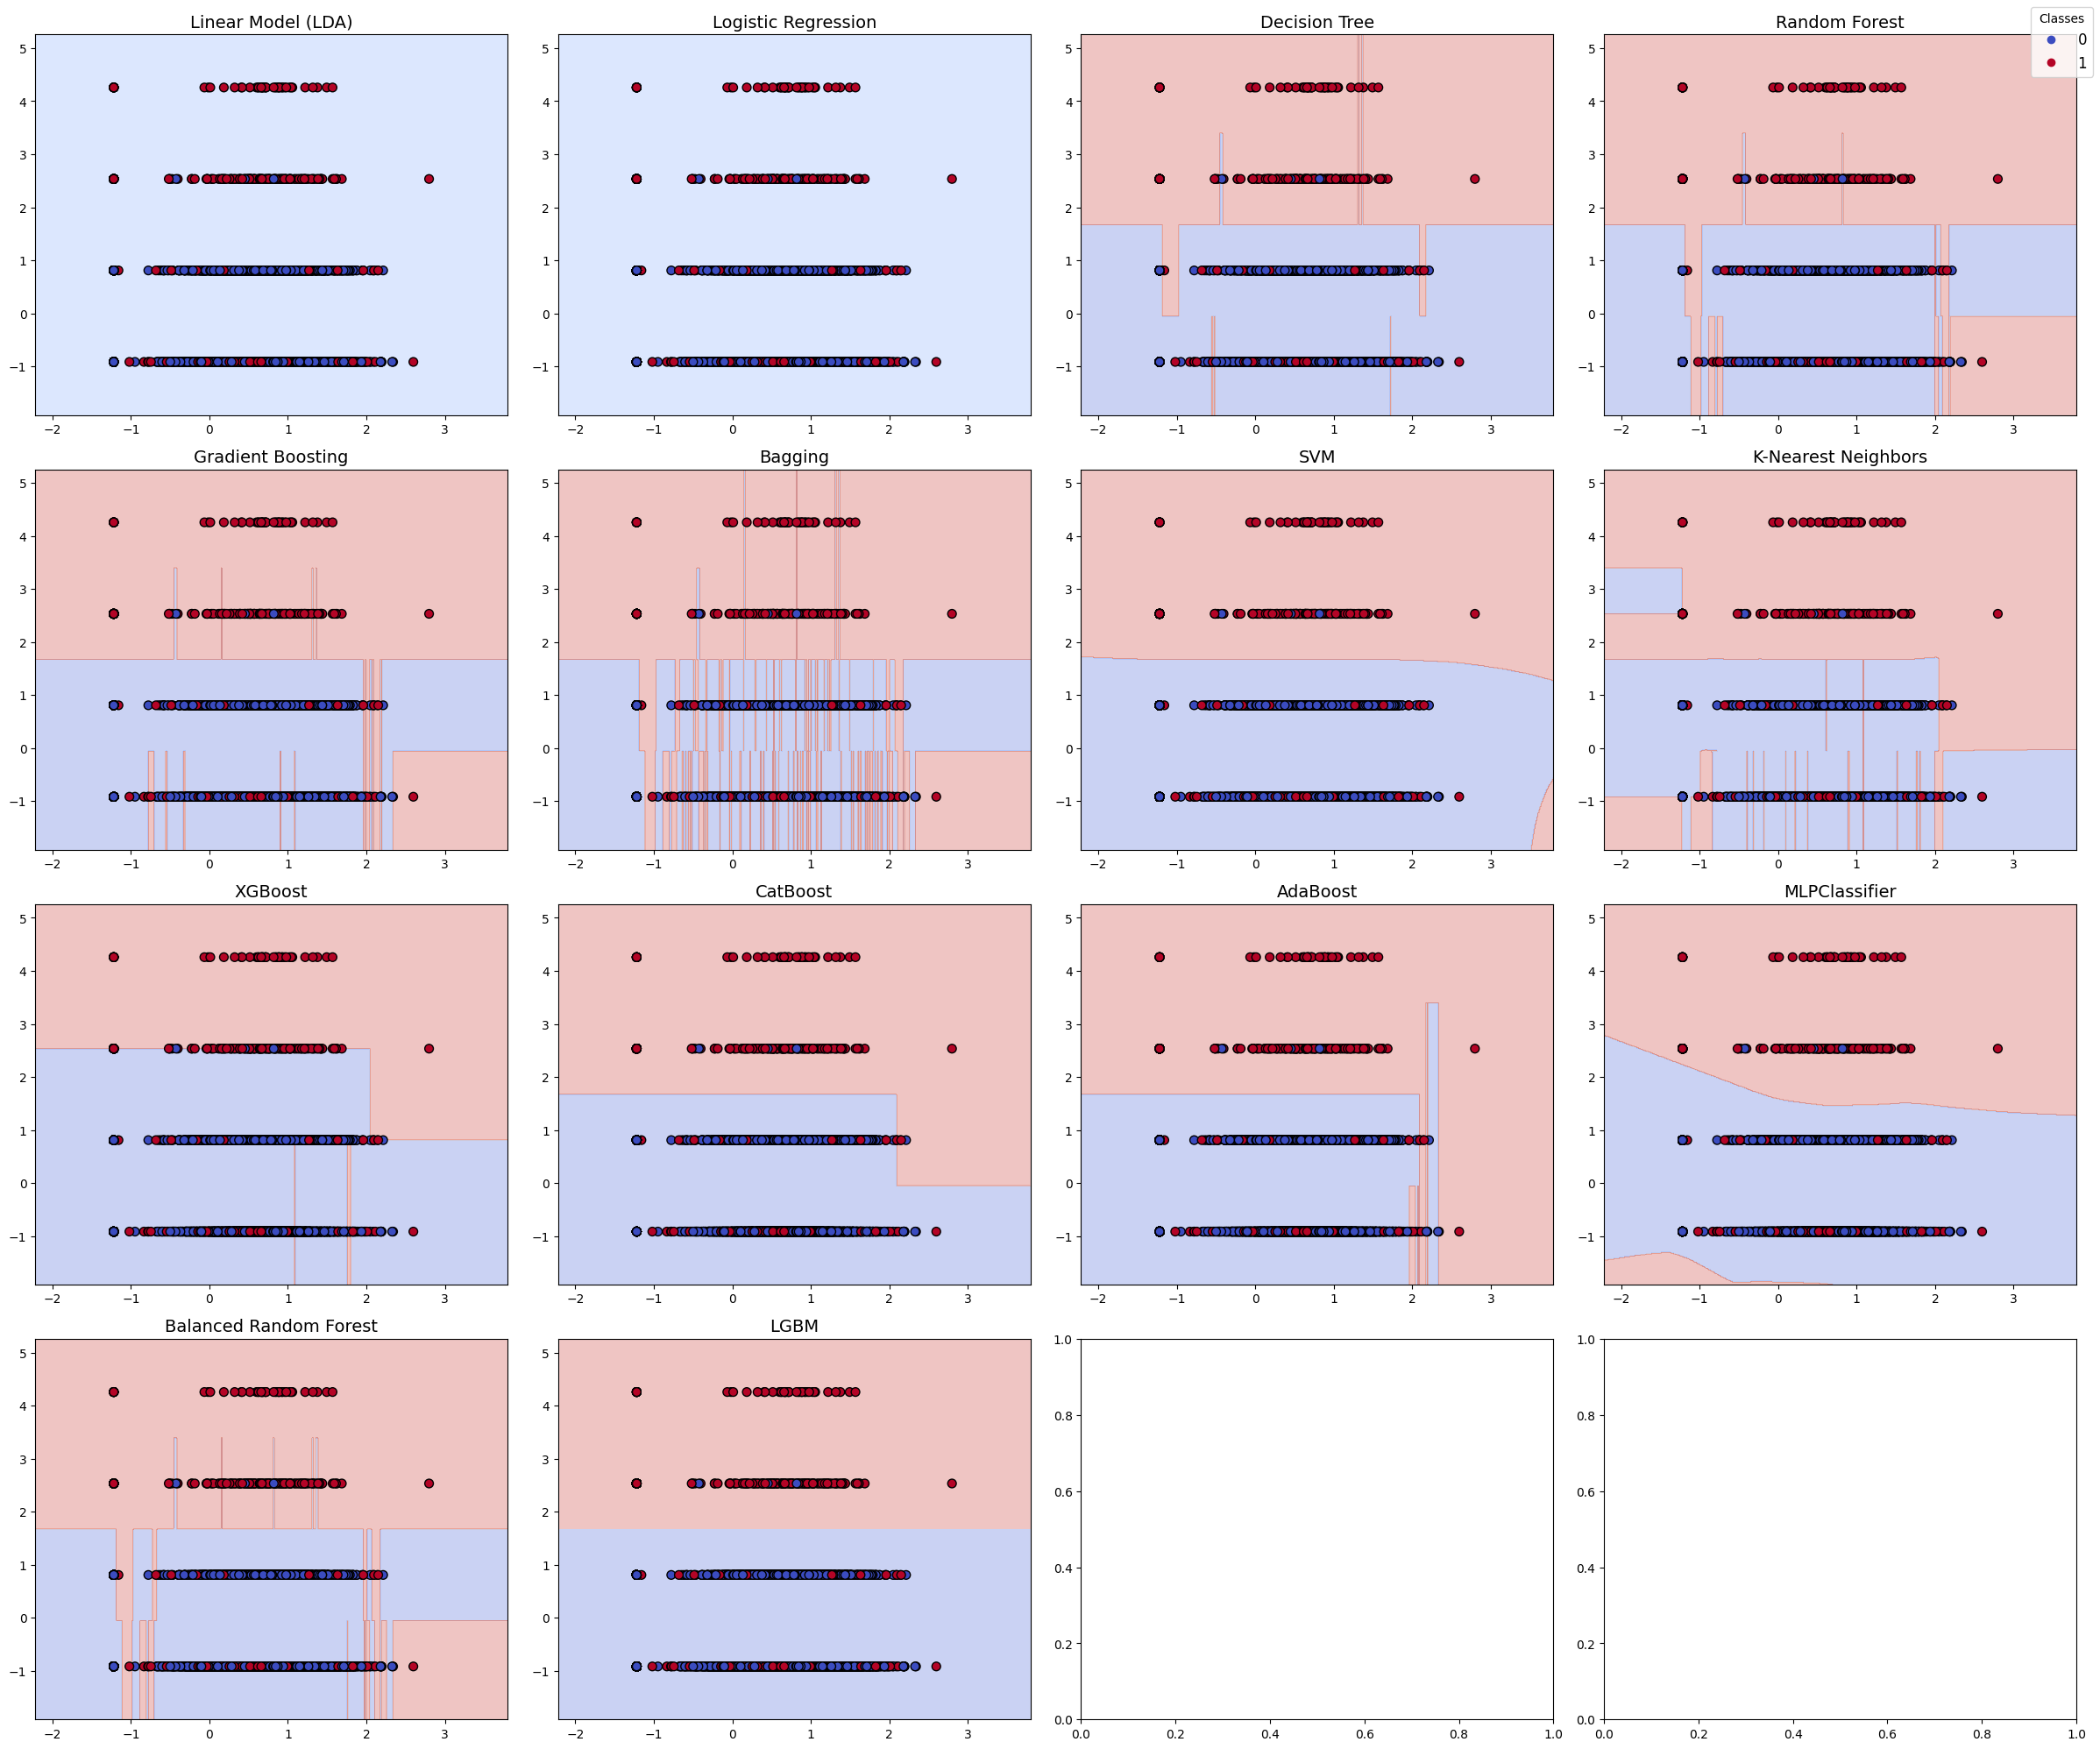

In [ ]:
X = dfw[['balance', 'products_number']]
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selected_models = {
    "Linear Model (LDA)": LDA(),
    "Logistic Regression": LogisticRegression(C=3.845401188473625),
    "Decision Tree": DecisionTreeClassifier(max_depth=6),
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=70),
    "Gradient Boosting": GradientBoostingClassifier(max_depth=4, n_estimators=124),
    "Bagging": BaggingClassifier(n_estimators=121),
    "SVM": SVC(C=6.086584841970366, probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": XGBClassifier(max_depth=4, n_estimators=124, use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(depth=6, iterations=142, verbose=0),
    "AdaBoost": AdaBoostClassifier(n_estimators=152),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,)),
    "Balanced Random Forest": RandomForestClassifier(max_depth=9, n_estimators=171),
    "LGBM": LGBMClassifier(learning_rate=0.11011258334170654, max_depth=6, num_leaves=182)
}

fig, axes = plt.subplots(4, 4, figsize=(24, 20))
axes = axes.flatten()
xx, yy = np.meshgrid(np.linspace(X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1, 500),
                     np.linspace(X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1, 500))

for ax, (name, model) in zip(axes, selected_models.items()):
    model.fit(X_train_scaled, y_train)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    scatter = ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, s=50, cmap=plt.cm.coolwarm, edgecolor='k')

    ax.set_title(name, fontsize=14)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

handles, labels = scatter.legend_elements()
fig.legend(handles, labels, loc='upper right', title='Classes', fontsize=12)

plt.tight_layout()
plt.show()


## SHAP and LIME

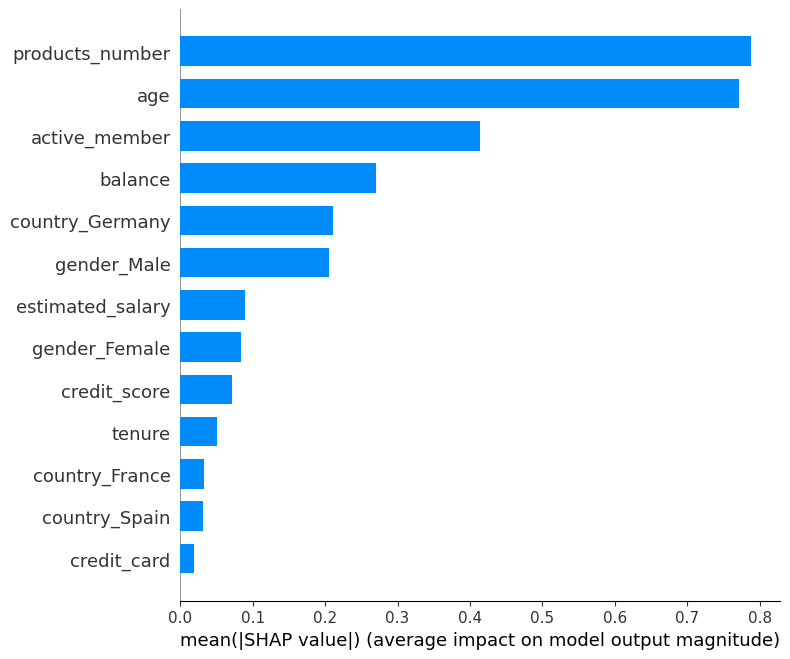

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="bar")

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_scaled[0,:], feature_names=X.columns.tolist())


In [ ]:
explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=['Not churn', 'Churn'],
    mode='classification'
)

i = 10
explanation = explainer.explain_instance(X_test_scaled[i], cat_model.predict_proba, num_features=5)

explanation.show_in_notebook(show_all=False)

## Ensemble Methods

Stacked LR - Mean CV Accuracy: 0.8655, Std Dev Accuracy: 0.0069, 95% CI Accuracy: (0.8559733385367941, 0.8750266614632062), Mean CV ROC AUC: 0.8679, Std Dev ROC AUC: 0.0090, 95% CI ROC AUC: (0.8554351840481647, 0.8804642972375867)
Stacked NN - Mean CV Accuracy: 0.8657, Std Dev Accuracy: 0.0089, 95% CI Accuracy: (0.8533527761986947, 0.8781472238013052), Mean CV ROC AUC: 0.8683, Std Dev ROC AUC: 0.0086, 95% CI ROC AUC: (0.8563160409101664, 0.8803073011919116)
Bagging Meta - Mean CV Accuracy: 0.8639, Std Dev Accuracy: 0.0050, 95% CI Accuracy: (0.8569686800012802, 0.8707813199987201), Mean CV ROC AUC: 0.8652, Std Dev ROC AUC: 0.0080, 95% CI ROC AUC: (0.8541537854073128, 0.8762795933655386)
AdaBoost Meta - Mean CV Accuracy: 0.8516, Std Dev Accuracy: 0.0043, 95% CI Accuracy: (0.8456995903048231, 0.8575504096951768), Mean CV ROC AUC: 0.8318, Std Dev ROC AUC: 0.0106, 95% CI ROC AUC: (0.8171020185504759, 0.8465974641558481)
Voting Soft - Mean CV Accuracy: 0.8649, Std Dev Accuracy: 0.0055, 95% C

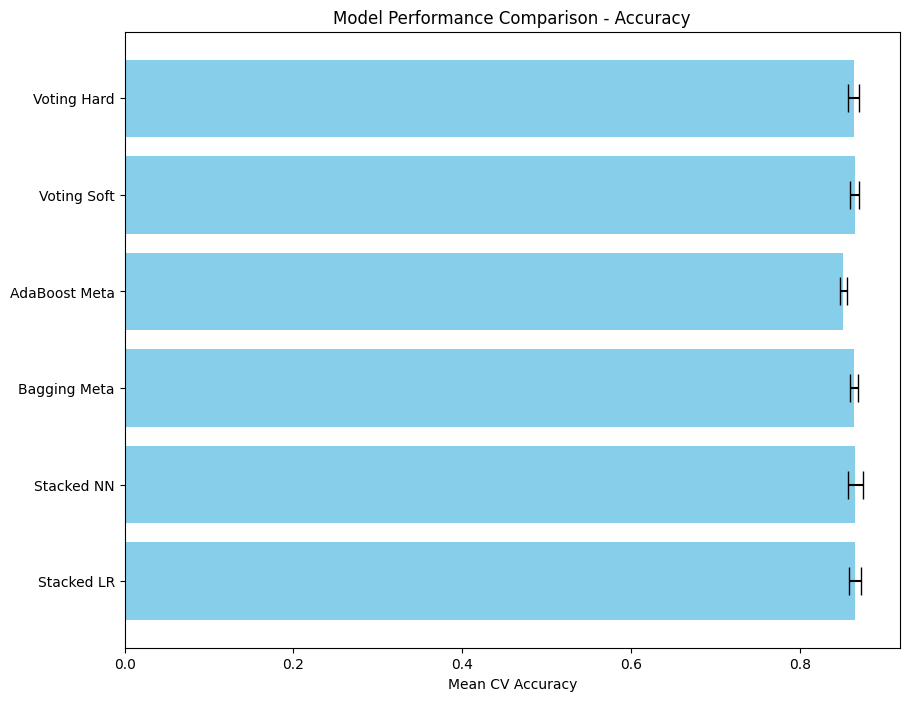

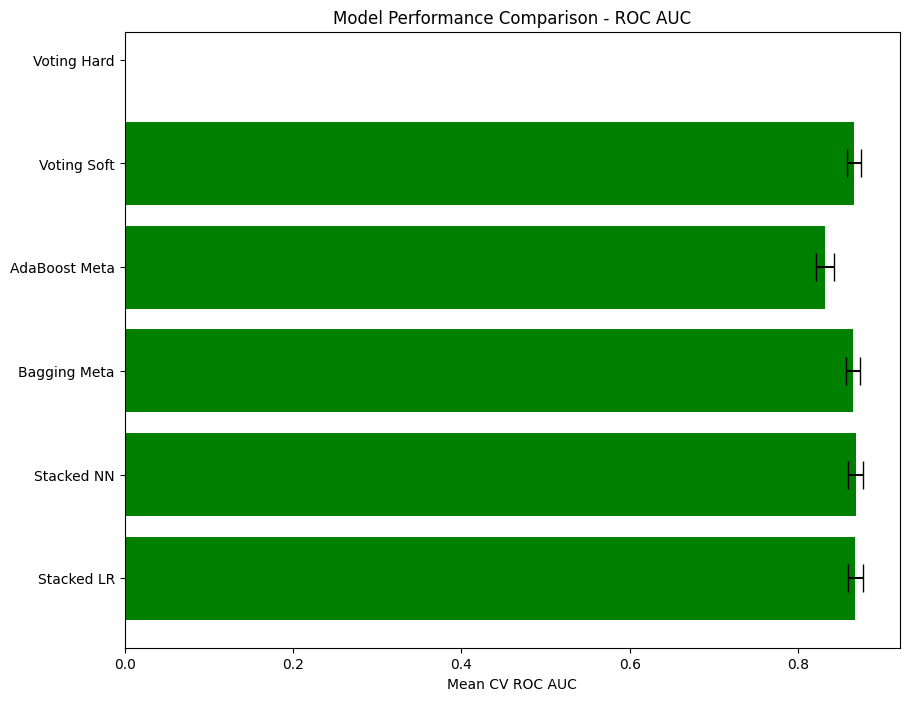

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_models = [
    ('gradient_boosting', GradientBoostingClassifier(max_depth=4, n_estimators=124)),
    ('random_forest', RandomForestClassifier(max_depth=7, n_estimators=70)),
    ('catboost', CatBoostClassifier(depth=6, iterations=142, verbose=0)),
    ('xgboost', XGBClassifier(max_depth=4, n_estimators=124, use_label_encoder=False, eval_metric='logloss'))
]

models = {
    'Stacked LR': StackingClassifier(estimators=base_models, final_estimator=LogisticRegression()),
    'Stacked NN': StackingClassifier(estimators=base_models, final_estimator=MLPClassifier()),
    'Bagging Meta': BaggingClassifier(base_estimator=VotingClassifier(estimators=base_models, voting='soft')),
    'AdaBoost Meta': AdaBoostClassifier(base_estimator=VotingClassifier(estimators=base_models, voting='soft')),
    'Voting Soft': VotingClassifier(estimators=base_models, voting='soft'),
    'Voting Hard': VotingClassifier(estimators=base_models, voting='hard')
}

results = {}
for name, model in models.items():
    cv_scores_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_accuracy = cv_scores_accuracy.mean()
    std_dev_accuracy = cv_scores_accuracy.std()
    ci_accuracy = t.interval(0.95, len(cv_scores_accuracy)-1, loc=mean_accuracy, scale=sem(cv_scores_accuracy))

    cv_scores_roc_auc = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    mean_roc_auc = cv_scores_roc_auc.mean()
    std_dev_roc_auc = cv_scores_roc_auc.std()
    ci_roc_auc = t.interval(0.95, len(cv_scores_roc_auc)-1, loc=mean_roc_auc, scale=sem(cv_scores_roc_auc))

    results[name] = {
        'Mean CV Accuracy': mean_accuracy,
        'Standard Deviation Accuracy': std_dev_accuracy,
        '95% CI Accuracy': ci_accuracy,
        'Mean CV ROC AUC': mean_roc_auc,
        'Standard Deviation ROC AUC': std_dev_roc_auc,
        '95% CI ROC AUC': ci_roc_auc
    }

    print(f"{name} - Mean CV Accuracy: {mean_accuracy:.4f}, Std Dev Accuracy: {std_dev_accuracy:.4f}, 95% CI Accuracy: {ci_accuracy}, Mean CV ROC AUC: {mean_roc_auc:.4f}, Std Dev ROC AUC: {std_dev_roc_auc:.4f}, 95% CI ROC AUC: {ci_roc_auc}")

fig, ax = plt.subplots(figsize=(10, 8))
names = list(results.keys())
means_accuracy = [results[name]['Mean CV Accuracy'] for name in names]
errors_accuracy = [results[name]['Standard Deviation Accuracy'] for name in names]
ax.barh(names, means_accuracy, xerr=errors_accuracy, align='center', color='skyblue', ecolor='black', capsize=10)
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Model Performance Comparison - Accuracy')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
means_roc_auc = [results[name]['Mean CV ROC AUC'] for name in names]
errors_roc_auc = [results[name]['Standard Deviation ROC AUC'] for name in names]
ax.barh(names, means_roc_auc, xerr=errors_roc_auc, align='center', color='green', ecolor='black', capsize=10)
ax.set_xlabel('Mean CV ROC AUC')
ax.set_title('Model Performance Comparison - ROC AUC')
plt.show()


In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_params = {
    "Decision Tree": {'max_depth': 6},
    "Random Forest": {'max_depth': 7, 'n_estimators': 70},
    "Gradient Boosting": {'max_depth': 4, 'n_estimators': 124},
    "SVM": {'C': 6.086584841970366},
    "XGBoost": {'max_depth': 4, 'n_estimators': 124},
    "CatBoost": {'depth': 6, 'iterations': 142},

}

base_models = [
    ('decision_tree', DecisionTreeClassifier(**best_params["Decision Tree"])),
    ('random_forest', RandomForestClassifier(**best_params["Random Forest"])),
    ('gradient_boosting', GradientBoostingClassifier(**best_params["Gradient Boosting"])),
    ('svm', SVC(**best_params["SVM"], probability=True)),
    ('xgboost', XGBClassifier(**best_params["XGBoost"])),
    ('catboost', CatBoostClassifier(verbose=0, **best_params["CatBoost"])),

]

stacked_lr = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
stacked_nn = StackingClassifier(estimators=base_models, final_estimator=MLPClassifier())
bagging_meta = BaggingClassifier(base_estimator=VotingClassifier(estimators=base_models, voting='soft'))
adaboost_meta = AdaBoostClassifier(base_estimator=VotingClassifier(estimators=base_models, voting='soft'))
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_hard = VotingClassifier(estimators=base_models, voting='hard')

models = {
    'Stacked LR': stacked_lr,
    'Stacked NN': stacked_nn,
    'Bagging Meta': bagging_meta,
    'AdaBoost Meta': adaboost_meta,
    'Voting Soft': voting_soft,
    'Voting Hard': voting_hard
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(cv_scores)
    std_error = sem(cv_scores)
    confidence_interval = t.interval(0.95, len(cv_scores)-1, loc=mean_score, scale=std_error)
    print(f"{name} - Mean CV Accuracy: {mean_score:.2f}, 95% Confidence Interval: {confidence_interval}")


Voting Soft - Mean CV Accuracy: 0.86, 95% Confidence Interval: (0.8563894549382917, 0.8686105450617084)
Voting Hard - Mean CV Accuracy: 0.86, 95% Confidence Interval: (0.8552991641378377, 0.8704508358621624)


In [ ]:
base_models = [
    ('decision_tree', DecisionTreeClassifier(**best_params["Decision Tree"])),
    ('random_forest', RandomForestClassifier(**best_params["Random Forest"])),
    ('gradient_boosting', GradientBoostingClassifier(**best_params["Gradient Boosting"])),
    ('bagging', BaggingClassifier(**best_params["Bagging"])),
    ('svm', SVC(**best_params["SVM"], probability=True)),
    ('xgboost', XGBClassifier(**best_params["XGBoost"])),
    ('catboost', CatBoostClassifier(verbose=0, **best_params["CatBoost"]))
]


base_models_predictions_train = {}
for index, (name, model) in enumerate(base_models):
    model.fit(X_train_scaled, y_train)
    base_models_predictions_train[name] = model.predict_proba(X_train_scaled)[:, 1]


X_meta_train = np.column_stack([preds for preds in base_models_predictions_train.values()])


scaler_meta = StandardScaler()
X_meta_train_scaled = scaler_meta.fit_transform(X_meta_train)


meta_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_meta_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


meta_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


meta_model.fit(X_meta_train_scaled, y_train, epochs=20, batch_size=128, validation_split=0.2)


base_models_predictions_test = {}
for name, model in base_models:
    base_models_predictions_test[name] = model.predict_proba(X_test_scaled)[:, 1]
X_meta_test = np.column_stack([preds for preds in base_models_predictions_test.values()])
X_meta_test_scaled = scaler_meta.transform(X_meta_test)


test_loss, test_accuracy = meta_model.evaluate(X_meta_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
50/50 [==============================] - 2s 19ms/step - loss: 0.1762 - accuracy: 0.9413 - val_loss: 0.0108 - val_accuracy: 0.9975
Epoch 2/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.0012 - val_accuracy: 0.9994
Epoch 3/20
50/50 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 3.5301e-04 - val_accuracy: 1.0000
Epoch 4/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.1958e-04 - val_accuracy: 1.0000
Epoch 5/20
50/50 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.1839e-04 - val_accuracy: 1.0000
Epoch 6/20
50/50 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 5.7210e-05 - val_accuracy: 1.0000
Epoch 7/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0020 - accuracy: 0.9989 - val_loss: 3.2097e-05 - val_accuracy: 1.00

In [ ]:
X = dfw.drop("churn", axis=1)
y = dfw["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_models = [
    ('decision_tree', DecisionTreeClassifier(**best_params["Decision Tree"])),
    ('random_forest', RandomForestClassifier(**best_params["Random Forest"])),
    ('gradient_boosting', GradientBoostingClassifier(**best_params["Gradient Boosting"])),
    ('bagging', BaggingClassifier(**best_params["Bagging"])),
    ('svm', SVC(**best_params["SVM"], probability=True)),
    ('catboost', CatBoostClassifier(verbose=0, **best_params["CatBoost"]))
]

base_models_predictions_train = {}
for index, (name, model) in enumerate(base_models):
    model.fit(X_train_scaled, y_train)
    base_models_predictions_train[name] = model.predict_proba(X_train_scaled)[:, 1]


X_meta_train = np.column_stack([preds for preds in base_models_predictions_train.values()])


scaler_meta = StandardScaler()
X_meta_train_scaled = scaler_meta.fit_transform(X_meta_train)


xgboost_meta = XGBClassifier()
xgboost_meta.fit(X_meta_train_scaled, y_train)


base_models_predictions_test = {}
for name, model in base_models:
    base_models_predictions_test[name] = model.predict_proba(X_test_scaled)[:, 1]
X_meta_test = np.column_stack([preds for preds in base_models_predictions_test.values()])
X_meta_test_scaled = scaler_meta.transform(X_meta_test)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8615
